In [1]:
import torch
from algo_reasoning.src.sampler import CLRSDataset
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ronaldalbert/Documents/env/algo_reasoning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from algo_reasoning.src.models.network import EncodeProcessDecode
from algo_reasoning.src.lightning.AlgorithmicReasoningTask import AlgorithmicReasoningTask 
from algo_reasoning.src.specs import CLRS_30_ALGS
from algo_reasoning.src.losses.AlgorithmicReasoningLoss import AlgorithmicReasoningLoss

# Define function for loading models

In [3]:
def load_models(algorithms):
    mpnn_ckpt_path = str(next(Path(f"../checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-mpnn0*")))
    spectral_ckpt_path = str(next(Path(f"../checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-spectralmpnn0*")))

    model_mpnn = EncodeProcessDecode(algorithms, processor='mpnn')
    model_spectral = EncodeProcessDecode(algorithms, processor='spectralmpnn2')

    loss_fn = AlgorithmicReasoningLoss()
    
    mpnn = AlgorithmicReasoningTask.load_from_checkpoint(mpnn_ckpt_path, model=model_mpnn, loss_fn=loss_fn, strict=False).model.to(device)
    spectral = model = AlgorithmicReasoningTask.load_from_checkpoint(spectral_ckpt_path, model=model_spectral, loss_fn=loss_fn, strict=False).model.to(device)

    mpnn.eval()
    spectral.eval()
    return mpnn, spectral

# Compute Fourier Features

In [4]:
def fourier_transform(embeddings, adj_matrix=None):
    """
    Compute the Fourier Transform of the embeddings.

    Args:
        embeddings: a tensor of shape (batch_size, sequence_length, embedding_dim)

    Returns:
        a tensor of shape (batch_size, sequence_length, embedding_dim)
    """
    if adj_matrix is None:
        adj_matrix = torch.ones((embeddings.size(0), embeddings.size(-2),embeddings.size(-2)), device=device)
    degrees = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.stack([torch.diag(degrees[d]) for d in range(degrees.size(0))], dim=0)
    laplacian = degree_matrix - adj_matrix
    
    result = torch.linalg.eigh(laplacian)
    eigenvalues = result.eigenvalues
    eigenvectors = result.eigenvectors
    
    eigenvalues[torch.isclose(eigenvalues, torch.tensor(0.))] = 0.

    return eigenvectors.transpose(-2, -1)@embeddings, eigenvectors, eigenvalues

# Load Default Algorithm Args

In [5]:
def load_algorithm_args(args_file):
    with open(args_file, 'r') as f:
        args = yaml.safe_load(f)

    return args

algorithm_args = "algorithm_args/default.yaml"

In [48]:
from algo_reasoning.src.models.encoder import preprocess
from algo_reasoning.src.specs import Stage, Location, Type, SPECS, CATEGORIES_DIMENSIONS

def accum_adj_matrix(adj_matrix, _input):
    _input = _input.squeeze(-1)
    adj_matrix += ((_input + _input.permute((0, 2, 1))) > 0.0)

    return adj_matrix


def build_adj_matrix(obj, batch_size, nb_nodes, algorithm, hint_step=None):
    adj_mat = (torch.eye(nb_nodes, device=device)[None, :, :]).repeat(batch_size, 1, 1).bool()
    
    for k, value in obj.inputs:
        if k not in SPECS[algorithm]:
            continue
            
        _, loc, type_ = SPECS[algorithm][k]
        _input = preprocess(value, type_, nb_nodes)

        if loc == Location.NODE and type_ == Type.POINTER:
            adj_mat = accum_adj_matrix(adj_mat, _input)
                
        elif loc == Location.EDGE and type_ == Type.MASK:
            adj_mat = accum_adj_matrix(adj_mat, _input)

    if hint_step is not None:
        for k, value in obj.hints:
            if k not in SPECS[algorithm]:
                continue

            
            _, loc, type_ = SPECS[algorithm][k]
            
            value = value[:, hint_step]
            _input = preprocess(value, type_, nb_nodes)

            if loc == Location.NODE and type_ == Type.POINTER:
                adj_mat = accum_adj_matrix(adj_mat, _input)
                    
            elif loc == Location.EDGE and type_ == Type.MASK:
                adj_mat = accum_adj_matrix(adj_mat, _input)

    return adj_mat.float()

def calculate_fourier_embeddings(embeddings, obj, batch_size, nb_nodes, algorithm, hint_step=None, mpnn=False):
    adj_matrix = build_adj_matrix(obj, batch_size, nb_nodes, algorithm)

    if mpnn:
        adj_matrix = torch.ones(batch_size, nb_nodes, nb_nodes, device=device)

    fourier_embeddings, eigenvectors, eigenvalues = fourier_transform(embeddings[:, hint_step], adj_matrix)

    return fourier_embeddings

In [7]:
algorithms = ["articulation_points"]

nb_nodes = 16
batch_size = 8
ds = CLRSDataset(algorithms, nb_nodes, batch_size, 1000, seed=7, algorithms_args=algorithm_args)

In [8]:
mpnn_model, spectral_model = load_models(algorithms)

obj = next(iter(ds)).to(device=device)

output_mpnn, output_spectral  = mpnn_model(obj), spectral_model(obj)
adj_matrix = obj.inputs.A
embeddings_mpnn, embeddings_spectral = output_mpnn.hidden_embeddings, output_spectral.hidden_embeddings

In [9]:
fourier_embeddings_mpnn, eigenvectors_mpnn, eigenvalues_mpnn = fourier_transform(embeddings_mpnn[:, 0], adj_matrix)
fourier_embeddings_spectral, eigenvectors_spectral, eigenvalues_spectral = fourier_transform(embeddings_spectral[:, 0], adj_matrix)

# Build Fourier Embeddings Plots

Error with algorithm segments_intersect


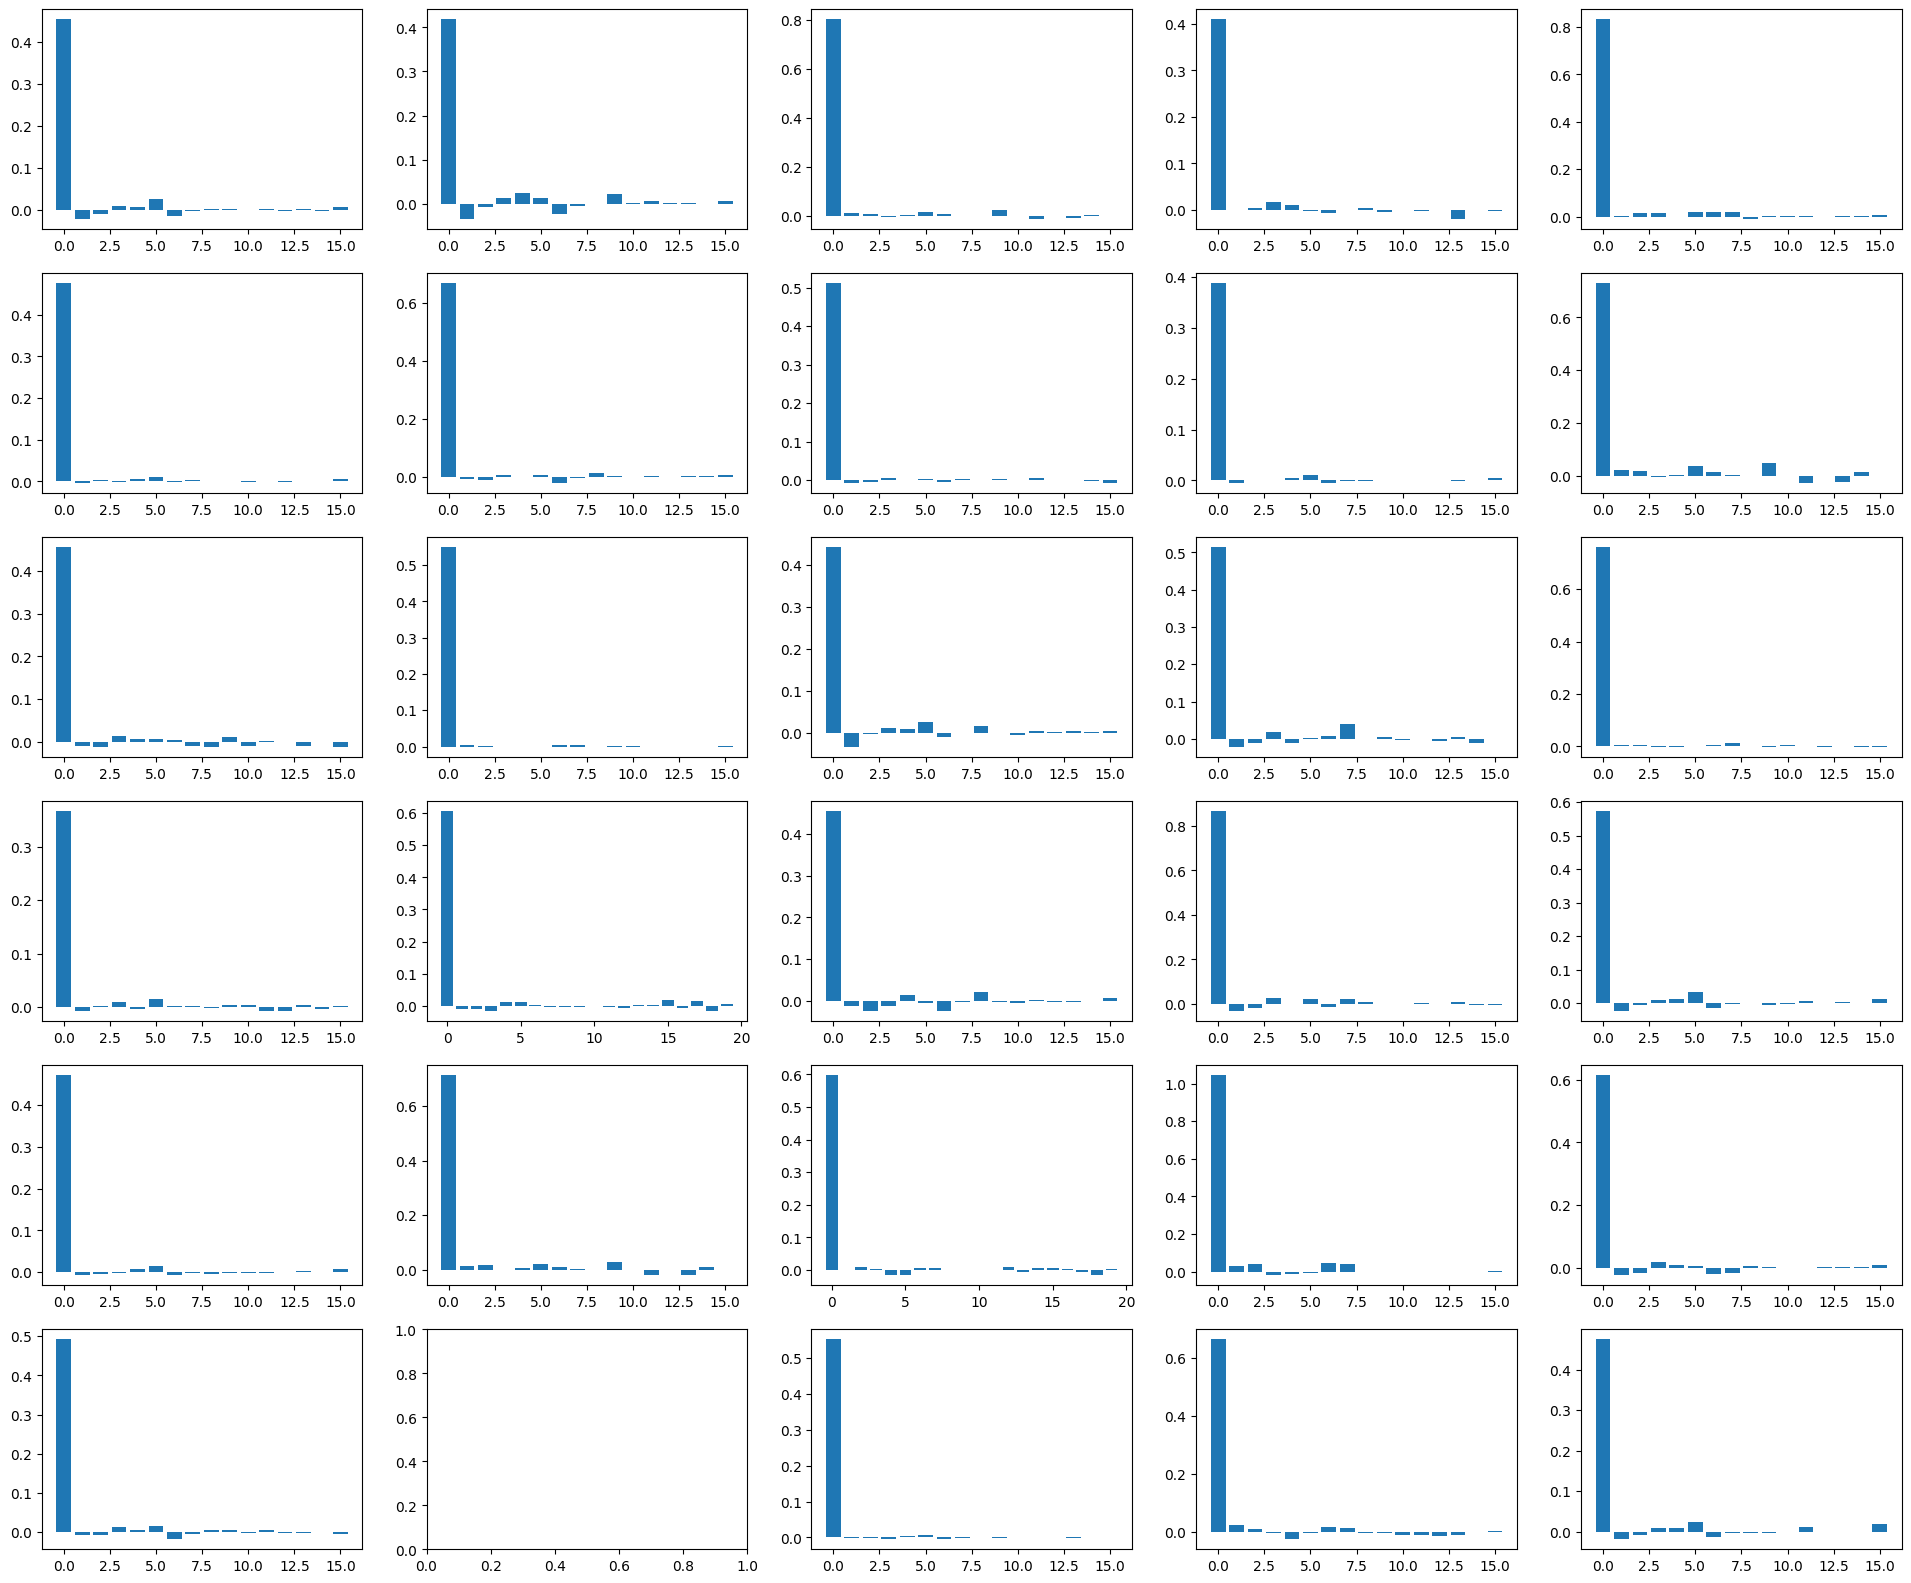

In [49]:
import matplotlib.pyplot as plt
from algo_reasoning.src.specs import CLRS_30_ALGS

hint_step = 0
batch_idx = -1
rows, columns = 6, 5

fig, axs = plt.subplots(rows, columns, figsize = (24, 20))

for i, algorithm in enumerate(CLRS_30_ALGS):
    row, column = i//columns, i % columns
    ax = axs[row, column]

    try:
        ds = CLRSDataset([algorithm], nb_nodes, batch_size, 1000, seed=7, algorithms_args=algorithm_args)
        mpnn_model, _ = load_models([algorithm])
    
        obj = next(iter(ds)).to(device=device)
        
        embeddings = mpnn_model(obj).hidden_embeddings
        fourier_embeddings = calculate_fourier_embeddings(embeddings, obj, batch_size, obj.inputs.pos.size(-1), algorithm, hint_step=hint_step, mpnn=True)
        
        plot_data = torch.mean(fourier_embeddings, dim=-1)
        
        ax.bar(x=[i for i in range(obj.inputs.pos.size(-1))], height=plot_data[batch_idx].detach().cpu().numpy())
    except:
        print(f"Error with algorithm {algorithm}")

Error with algorithm segments_intersect


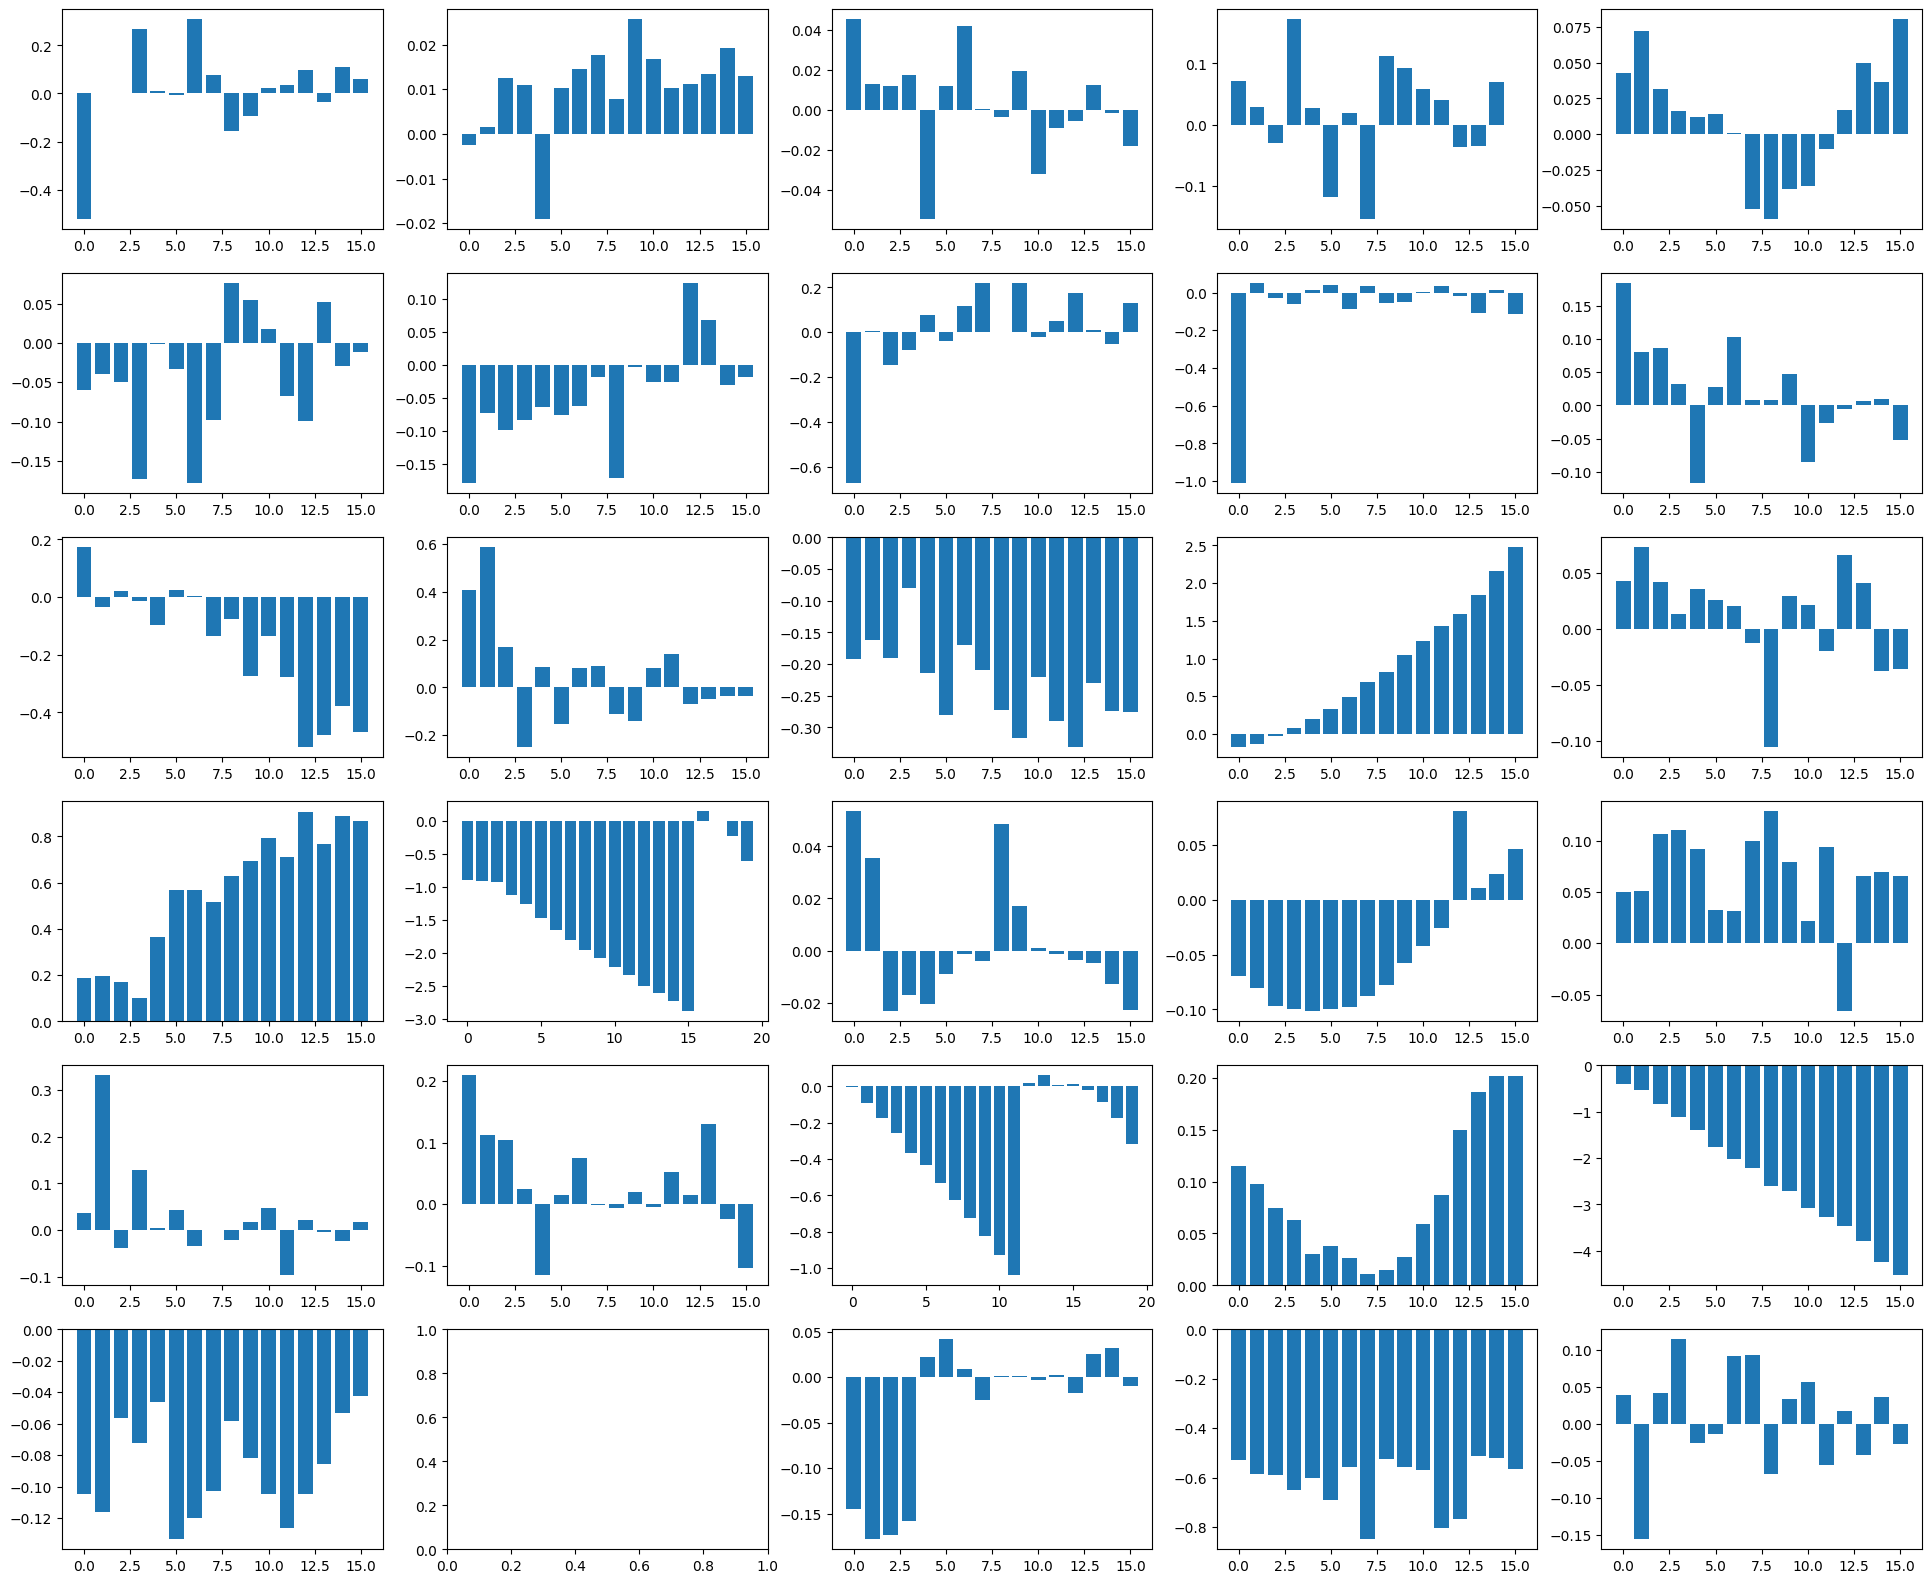

In [51]:
import matplotlib.pyplot as plt
from algo_reasoning.src.specs import CLRS_30_ALGS

hint_step = 0
batch_idx = -1
rows, columns = 6, 5

fig, axs = plt.subplots(rows, columns, figsize = (24, 20))

for i, algorithm in enumerate(CLRS_30_ALGS):
    row, column = i//columns, i % columns
    ax = axs[row, column]

    try:
        ds = CLRSDataset([algorithm], nb_nodes, batch_size, 1000, seed=7, algorithms_args=algorithm_args)
        _, spectral_model = load_models([algorithm])
    
        obj = next(iter(ds)).to(device=device)
        
        embeddings = spectral_model(obj).hidden_embeddings
        fourier_embeddings = calculate_fourier_embeddings(embeddings, obj, batch_size, obj.inputs.pos.size(-1), algorithm, hint_step=hint_step, mpnn=False)
        
        plot_data = torch.mean(fourier_embeddings, dim=-1)
        
        ax.bar(x=[i for i in range(obj.inputs.pos.size(-1))], height=plot_data[batch_idx].detach().cpu().numpy())
    except:
        print(f"Error with algorithm {algorithm}")